# Paper figures

In [1]:
# Import relevant libraries
import numpy as np
import scanpy as sc
import os
import pandas as pd
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
from collections import OrderedDict
from matplotlib import cm
import anndata as ann
import scanpy.external as sce
from datetime import datetime
import NaiveDE
import SpatialDE
from matplotlib_venn import venn3
%matplotlib inline
import glob
from sklearn.metrics import mean_squared_error as mse
from scipy import stats

# Set current directory
os.chdir("/Users/mendenlab/work/spatial_granuloma/scripts")

# assign the rigth colours to the right annotation
def _set_colors(adata, obs_name, colors):
    """Set palette with specific colors for specific categories

    Parameters
    ----------
    adata : annData
    obs_name : column to plot
    colors : OrderedDict(): colors named by categories

    Returns
    -------

    """
    if len(colors.values())>0:
        palette = []
        unique_colors = np.unique(adata.obs[obs_name])
        for key in adata.obs[obs_name].cat.categories.tolist():
            if key in colors.keys():
                palette.append(colors[key])
    return palette

#Set the colours per annotation
spot_colors = []
spot_colors = OrderedDict()
spot_colors["EPIDERMIS"] = 'blue'
spot_colors["DERMIS"] = '#E0EEE0'
spot_colors["INTERFACE"] = 'deepskyblue'
spot_colors["VESSEL"] = 'darkgreen'
spot_colors["HAIR FOLLICLE"] = "#543005"
spot_colors["SWEAT GLAND"] = 'y'
spot_colors["SEBACEOUS GLAND"] = 'mistyrose'
spot_colors["MUSCLE"] = 'darkcyan'
spot_colors["GA"] = 'firebrick'  
spot_colors["GNL"] = 'orchid'
spot_colors["GSS"] = 'blueviolet'
spot_colors["GSC"] = 'mediumvioletred'
spot_colors["UNDETERMINED"] = 'black'


dermis_colors = []
dermis_colors = OrderedDict()
dermis_colors["UNDETERMINED"] = 'black'
dermis_colors["upper EPIDERMIS"] = 'blue'
dermis_colors["middle EPIDERMIS"] = 'dodgerblue'
dermis_colors["basal EPIDERMIS"] = 'skyblue'
dermis_colors["DERdepth1"] = '#006837'
dermis_colors["DERdepth2"] = '#238443'
dermis_colors["DERdepth3"] = '#41AB5D'
dermis_colors["DERdepth4"] = '#78C679'
dermis_colors["DERdepth5"] = '#ADDD8E'
dermis_colors["DERdepth6"] = '#D9F0A3'
dermis_colors["DERdepth7"] = '#F7FCB9'

leiden_r13_colours = []
leiden_r13_colours = OrderedDict()
leiden_r13_colours["0"] = 'darkolivegreen'
leiden_r13_colours["1"] = "#D9F0A3"
leiden_r13_colours["2"] = '#238443'
leiden_r13_colours["3"] = 'firebrick'
leiden_r13_colours["4"] = '#78C679'
leiden_r13_colours["5"] = '#78C679'
leiden_r13_colours["6"] = '#41AB5D'
leiden_r13_colours["7"] = '#006837'
leiden_r13_colours["8"] = '#ADDD8E'
leiden_r13_colours["9"] = "#238443"
leiden_r13_colours["10"] = '#78C679'
leiden_r13_colours["11"] = 'blue'
leiden_r13_colours["12"] = 'orchid'
leiden_r13_colours["13"] = '#F46D43'
leiden_r13_colours["14"] = 'dodgerblue'
leiden_r13_colours["15"] = 'deepskyblue'
leiden_r13_colours["16"] = '#cfafaf'
leiden_r13_colours["17"] = 'yellow'
leiden_r13_colours["18"] = 'darkcyan'
leiden_r13_colours["19"] = '#006837'

In [2]:
# To create a pdf with all the spatial info proyected onto the tissue images
# obs name --> by what colours you want to plot, my colours --> colour dictionary
# filename --> where to save it to
# handles and labels --> to have only 1 legend for all plots. 


def _plot_spatial_all_slides(adata = None, obs_name = 'spot_type', my_colors = None,
                             filename = 'test.pdf',
                             handles = None, labels = None):
    """Plot all 12 capture areas

    Parameters
    ----------


    Returns
    -------

    """
    fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(35, 10), dpi=300)
    fig.subplots_adjust(bottom=0.05, left=0.05, top=0.95, right=0.87)
    axes.axis("off")
    k=1
    for key in adata.uns['spatial'].keys():
        print(key)
        ax = fig.add_subplot(2, 6, k)
        adata_key = adata[adata.obs['sample']==key]
        if adata_key.n_obs>0 :
            if my_colors==None :
                #sc.pl.spatial(adata2, size=1, img_key='lowres',
                #              color='LESIONAL', #palette=_set_colors(adata2, 'spot_type', spot_colors),
                #              zorder=2, alpha_img=1, ax=ax)
                sc.pl.spatial(adata_key, size=1, img_key='hires', library_id=key,
                              color=obs_name,
                              zorder=2, alpha_img=1, ax=ax,
                              show=False, title=key)
                ax.axis("off")
                if ((k==2) | (k==10) | (k==6)):      #to invert orientation for some capture areas
                    ax.invert_xaxis()
                    ax.invert_yaxis()

            else :
                #sc.pl.spatial(adata2, size=1, img_key='lowres',
                #              color='LESIONAL', #palette=_set_colors(adata2, 'spot_type', spot_colors),
                #              zorder=2, alpha_img=1, ax=ax)
                sc.pl.spatial(adata_key, size=1, img_key='hires', library_id=key,
                              legend_loc='upper right',
                              color=obs_name, palette=_set_colors(adata_key, obs_name, my_colors),
                              zorder=2, alpha_img=1, ax=ax,
                              show=False, title=key)
                ax.axis("off")
                if ((k==2) | (k==10) | (k==6)):
                    ax.invert_xaxis() 
                    ax.invert_yaxis()

        k=k+1

    if (handles!=None) & (labels!=None):
        fig.legend(handles, labels, loc='center right')
        
    if (filename!=None) :
        plt.savefig(filename)
    
    plt.show()
    
    return fig, axes

In [3]:
# Import adata (latest version)
adata_path = "../results/current/"

adata = sc.read(os.path.join(adata_path, "final/adata_deg.h5"))
    
# setting up "factors" with different levels, order = TRUE
# add less common annotations LAST so they are not overwritten

# Set spot_type and skin_layer as categories and define the levels in each category
# Spot type: annatomical annotations
adata.obs['spot_type'] = pd.Categorical(
    adata.obs['spot_type'],
    categories = ['UNDETERMINED', 'DERMIS', "EPIDERMIS", 'INTERFACE', 'HAIR FOLLICLE',
                'VESSEL', 'MUSCLE', 'SEBACEOUS GLAND', 'SWEAT GLAND', 'GA', 'GNL', 'GSS', 'GSC'],
                 ordered = True)

# Skin layer
adata.obs['skin_layer'] = pd.Categorical(
    adata.obs['skin_layer'],
    categories = ['UNDETERMINED', 
                'upper EPIDERMIS', 'middle EPIDERMIS', 'basal EPIDERMIS',
                'DERdepth1', 'DERdepth2', 'DERdepth3', 'DERdepth4',
                'DERdepth5', 'DERdepth6', 'DERdepth7'],
    ordered = True)

/Users/mendenlab/miniconda3/envs/r4.1.2_py3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata

AnnData object with n_obs × n_vars = 15777 × 15107
    obs: 'indexes', 'sample', 'project', 'slide', 'in_tissue', 'array_row', 'array_col', 'ANNOTATOR', 'DISEASE', 'disease', 'SAMPLE', 'LESIONAL', 'NON LESIONAL', 'upper EPIDERMIS', 'middle EPIDERMIS', 'basal EPIDERMIS', 'DERMIS', 'DERdepth1', 'DERdepth2', 'DERdepth3', 'DERdepth4', 'DERdepth5', 'DERdepth6', 'DERdepth7', 'INTERFACE', 'VESSEL', 'HAIR FOLLICLE', 'SWEAT GLAND', 'SEBACEOUS GLAND', 'MUSCLE', 'FAT TISSUE', 'KERATINOCYTE', 'ENDOTHELIAL', 'GRANULOMA', 'BIOBANK', 'SPECIMEN', 'GA', 'GNL', 'GSC', 'GSS', 'EPIDERMIS', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'library_id', 'batch', 'specimen', 'patient', 'biopsy_type', 'cell_type', 'tissue_type', 'skin_layer', 'spot_type', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors', 'leiden_r5', 'leiden_r3', 'leiden_r1.5', 'leiden_r1.3', 'leiden_r1.0', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.3', 'leiden_r5_patient', 'leiden_r3_patient', 'leiden_r1.5_patien

In [5]:
os.chdir("/Volumes/Drive/spatial_granuloma/output/Paper_figures/") # Set working directory so it saves it in the drive
print(os.getcwd())

/Volumes/Drive/spatial_granuloma/output/Paper_figures


## Figure 3: SpatialDE

Trying to set attribute `._uns` of view, copying.


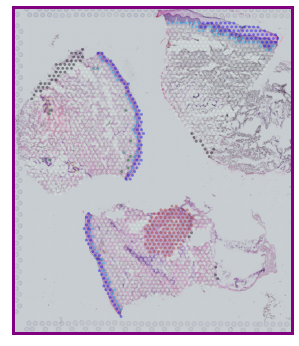

In [67]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.spatial(adata[adata.obs['sample']=='P18554_1001'],
              library_id = 'P18554_1001', 
              ax = ax, title= '', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample']=='P18554_1001'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = 'hires', alpha_img = 1, alpha = 0.4,
              frameon = True)
# for the frame around the image
ax.spines[:].set_color('purple') 
ax.spines[:].set_linewidth(3)
# x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis = 'off'

Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.


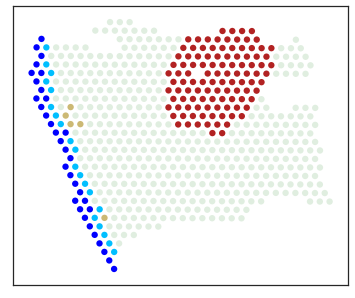

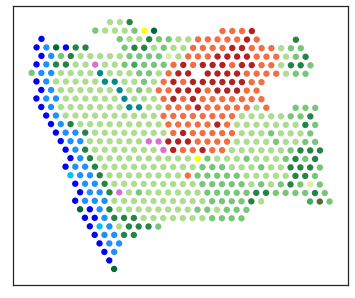

In [68]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
              library_id = 'P18554_1001', 
              ax = ax, title= '', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis = 'off'

fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
              library_id = 'P18554_1001', 
              ax = ax, title= '', 
              color = 'leiden_r1.3_patient', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
                                  'leiden_r1.3_patient', leiden_r13_colours),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis = 'off'

Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.


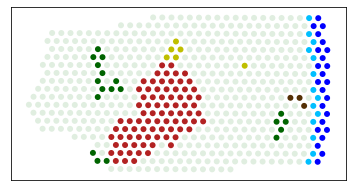

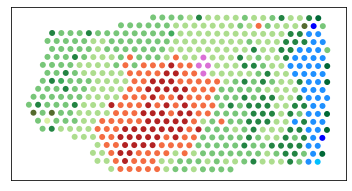

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1002_50107-A'],
              library_id = 'P18554_1002', 
              ax = ax, title= '', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1002_50107-A'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis = 'off'

fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1002_50107-A'],
              library_id = 'P18554_1002', 
              ax = ax, title= '', 
              color = 'leiden_r1.3_patient', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1002_50107-A'],
                                  'leiden_r1.3_patient', leiden_r13_colours),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis = 'off'

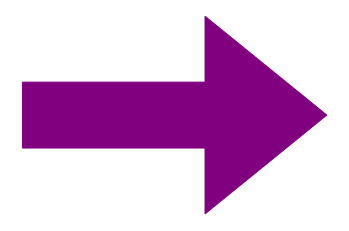

In [9]:
fig, axes = plt.subplots(1,1)
axes.arrow(0, 2, 30, 0, head_width = 0.003, 
         head_length = 20, color = 'purple')
axes.spines[:].set_visible(False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, # ticks along the top edge are off
    left=False, 
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.


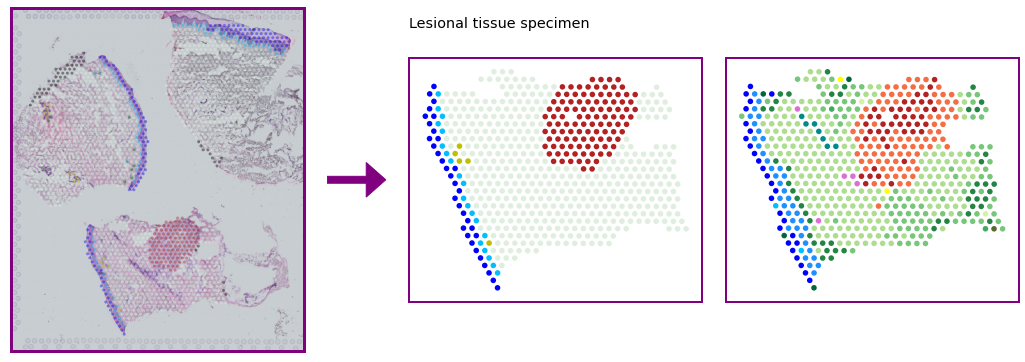

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 0.2, 1, 1]})
plt.rcParams['axes.titley'] = 1.1 # height of the titles
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams['axes.titlesize'] = 'x-large'

# First plot
sc.pl.spatial(adata[adata.obs['sample']=='P18554_1001'],
              library_id = 'P18554_1001', 
              ax = ax[0], title= '', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample']=='P18554_1001'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = 'hires', alpha_img = 1, alpha = 0.4,
              frameon = True)
# for the frame around the image
ax[0].spines[:].set_color('purple') 
ax[0].spines[:].set_linewidth(3)
# x and y labels
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].axis = 'off'


## ARROW
ax[1].set_xlim(0, 6)
ax[1].set_ylim(-1, 1)
ax[1].arrow(0, 0, 4, 0, 
            width = 0.04,
            head_width = 0.2, head_length = 2, 
            color = 'purple')
ax[1].spines[:].set_visible(False)
ax[1].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, # ticks along the top edge are off
    left=False, 
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

## spot type
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
              library_id = 'P18554_1001', 
              ax = ax[2], title= 'Lesional tissue specimen', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax[2].title.set_size(30)
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].axis = 'off'
ax[2].spines[:].set_color('purple') 
ax[2].spines[:].set_linewidth(2)

## leiden clusters
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
              library_id = 'P18554_1001', 
              ax = ax[3], title= '', 
              color = 'leiden_r1.3_patient', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
                                  'leiden_r1.3_patient', leiden_r13_colours),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax[3].title.set_size(18)
ax[3].set_xlabel('')
ax[3].set_ylabel('')
ax[3].axis = 'off'
ax[3].spines[:].set_color('purple') 
ax[3].spines[:].set_linewidth(2)


#fig.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.05)

#plt.savefig('Figure3_SpatialDE/lesional_zoom_figure.png', facecolor=fig.get_facecolor(), edgecolor='none')

In [11]:
plt.savefig('Figure3_SpatialDE/lesional_zoom_figure.png')

<Figure size 432x288 with 0 Axes>

In [12]:
rcParams.keys()


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

In [21]:
df_all = pd.read_csv('Figure3_SpatialDE/patterns_samples_merged.csv', index_col = 0)
patterns_columns = ['0', '1', '2', '3', '4', '5', '6', '7']

In [14]:
np.arange(0, 2.1, 1)

array([0., 1., 2.])

In [15]:
cbar

NameError: name 'cbar' is not defined

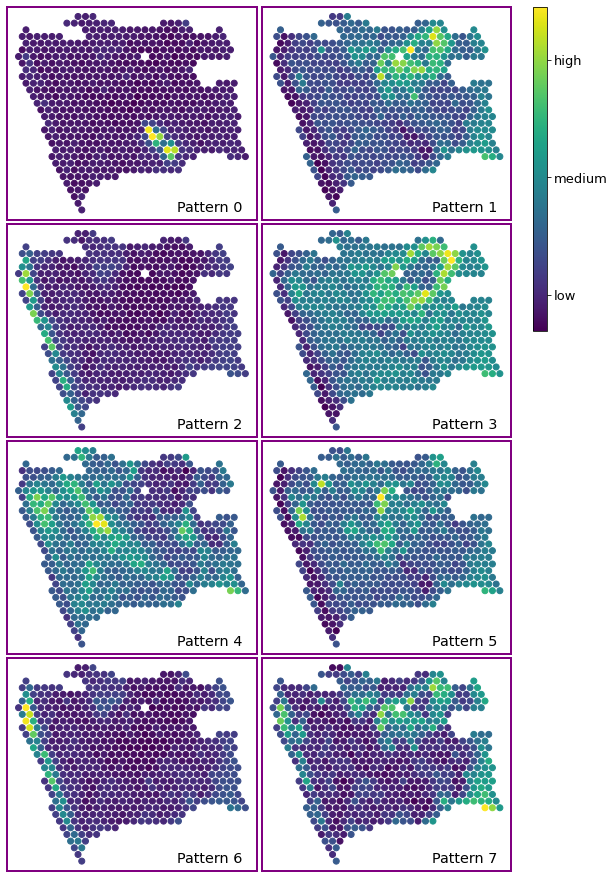

In [17]:
adata_subset = df_all[(df_all['sample_SPECIMEN']== 'P18554_1001_50107-A')] # define here the sample_SPECIMEN you want to display

plt.rcParams['axes.titley'] = 0.01 # height of the titles
plt.rcParams['axes.titlelocation'] = 'right'

fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(10, 15))
for i, pattern in enumerate(patterns_columns):
    ax = plt.subplot(4, 2, i + 1)
    #ax.set_axis_off() # this removes everything around
    ax.spines[:].set_color('purple')
    ax.spines[:].set_linewidth(2)
    ax.tick_params(axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False, # ticks along the top edge are off
                    left=False, 
                    labelleft=False,
                    labelbottom=False) # labels along the bottom edge are off
    
    im = plt.scatter(adata_subset['array_col'], 
                -1.5*adata_subset['array_row'],
                c = adata_subset[pattern]) # define here the pattern you want to display
    plt.title('Pattern {}   '.format(i))
    plt.colorbar().remove()
#     if(i != 3):
#         plt.colorbar().remove()
#     else:
#         cbar = plt.colorbar() # get the colour bar for the last plot
#         cbar.set_ticks(np.arange(adata_subset[pattern].min() + 0.4, 
#                                  adata_subset[pattern].max() - 0.4, 
#                                  (adata_subset[pattern].max() - adata_subset[pattern].min())/3))
#         cbar.set_ticklabels(['low', 'medium', 'high'])
#         plt.colorbar().remove() 
#         cbar.remove()
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.6, 0.02, 0.3])# left, bottom, width, height
cbar = fig.colorbar(im, cax = cb_ax)
cbar.set_ticks(np.arange(-0.25, 1.25, 0.72))
cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)

#plt.savefig('Figure3_SpatialDE/patterns_sharedlegend.png', facecolor=fig.get_facecolor(), edgecolor='none')

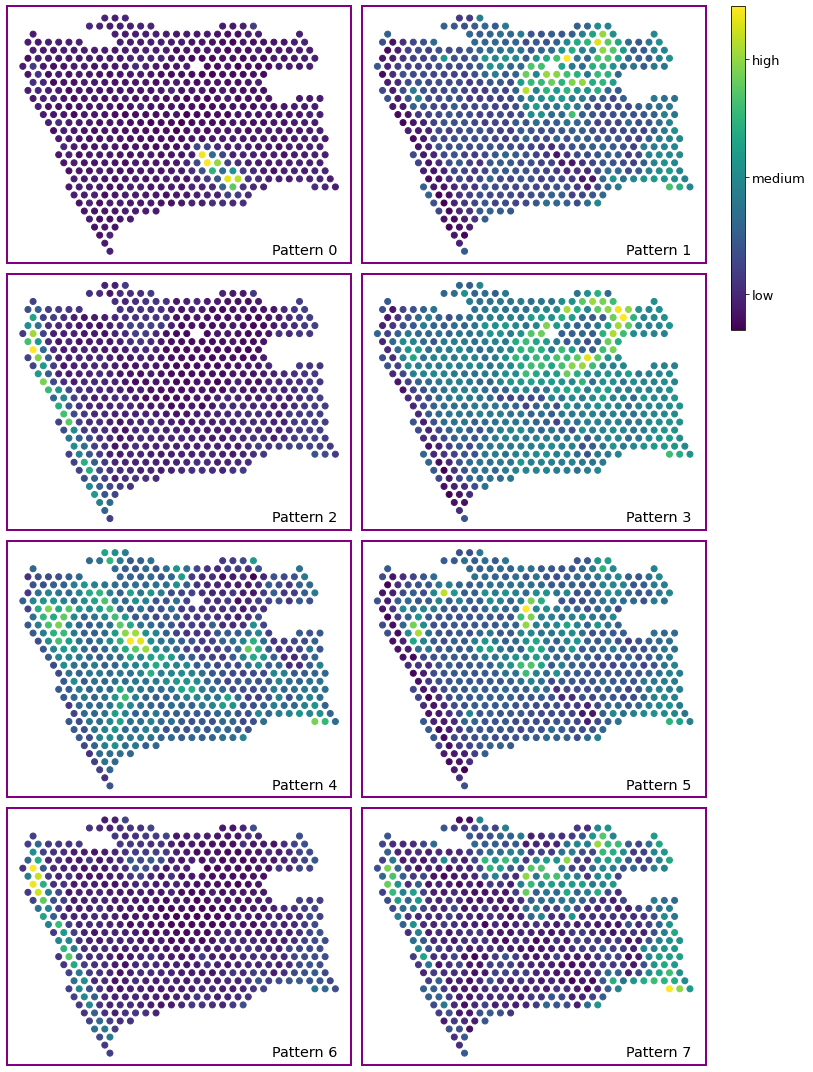

In [575]:
adata_subset = df_all[(df_all['sample_SPECIMEN']== 'P18554_1001_50107-A')] # define here the sample_SPECIMEN you want to display

plt.rcParams['axes.titley'] = 0.01 # height of the titles
plt.rcParams['axes.titlelocation'] = 'right'

fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(10, 15))
for i, pattern in enumerate(patterns_columns):
    ax = plt.subplot(4, 2, i + 1)
    #ax.set_axis_off() # this removes everything around
    ax.spines[:].set_color('purple')
    ax.spines[:].set_linewidth(2)
    ax.tick_params(axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False, # ticks along the top edge are off
                    left=False, 
                    labelleft=False,
                    labelbottom=False) # labels along the bottom edge are off
    
    im = plt.scatter(adata_subset['array_col'], 
                -1.5*adata_subset['array_row'],
                c = adata_subset[pattern]) # define here the pattern you want to display
    plt.title('Pattern {}   '.format(i))
    plt.colorbar().remove()
#     if(i != 3):
#         plt.colorbar().remove()
#     else:
#         cbar = plt.colorbar() # get the colour bar for the last plot
#         cbar.set_ticks(np.arange(adata_subset[pattern].min() + 0.4, 
#                                  adata_subset[pattern].max() - 0.4, 
#                                  (adata_subset[pattern].max() - adata_subset[pattern].min())/3))
#         cbar.set_ticklabels(['low', 'medium', 'high'])
#         plt.colorbar().remove() 
#         cbar.remove()
fig.tight_layout()
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
#                     wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([1.02, 0.69, 0.02, 0.3])# left, bottom, width, height
cbar = fig.colorbar(im, cax = cb_ax)
cbar.set_ticks(np.arange(-0.25, 1.25, 0.72))
cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)

plt.savefig('Figure3_SpatialDE/patterns_sharedlegend_tight.png', facecolor=fig.get_facecolor(), edgecolor='none')

## Top 12 genes

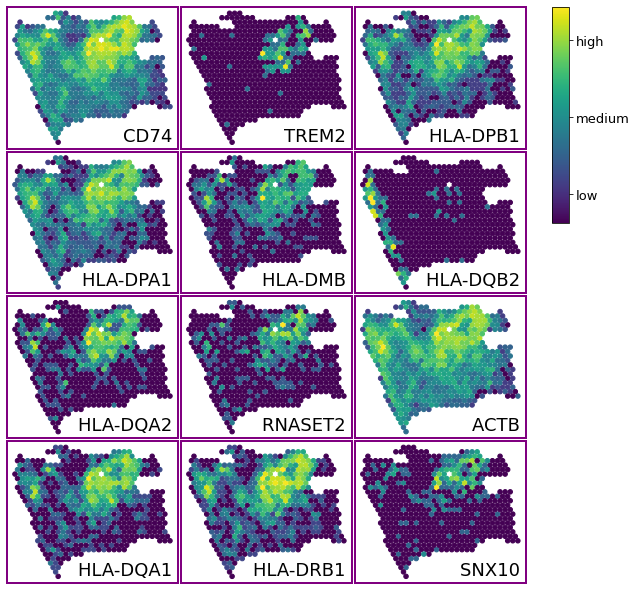

In [20]:
sample_SPECIMEN_list = ['P18554_1001_50107-A']
timestamp = '20220511' # the timestamp of the files (check filename)
for sample_SPECIMEN in sample_SPECIMEN_list:
    # Subset adata 
    adata_sample_SPECIMEN = adata[(adata.obs['sample_SPECIMEN']== sample_SPECIMEN)].copy()
    
    # Load the data for the particular sample
    results = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_results_' + sample_SPECIMEN + '.csv')
    sample_info = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_sample_info_' + sample_SPECIMEN + '.csv')
    counts = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_counts_' + sample_SPECIMEN + '.csv')
    norm_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_norm_expr_' + sample_SPECIMEN + '.csv')
    resid_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_resid_expr_' + sample_SPECIMEN + '.csv')
    
    genes = results.sort_values('qval').head(12)['g'].tolist()
    # Plot genes in spatial slides - top 12 by qval
    fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(12, 10))
    for i, g in enumerate(genes):
        ax = plt.subplot(4, 3, i + 1)
        ax.spines[:].set_color('purple')
        ax.spines[:].set_linewidth(2)
        ax.tick_params(axis='both',          # changes apply to the x-axis
                       which='both',      # both major and minor ticks are affected
                       bottom=False,      # ticks along the bottom edge are off
                       top=False, # ticks along the top edge are off
                       left=False, 
                       right=False, # ticks along the top edge are off
                       labelleft=False,
                       labelbottom=False) # labels along the bottom edge are off
        if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
            ax.invert_xaxis() 
            ax.invert_yaxis()
        im = plt.scatter(sample_info['array_col'], -1.5*sample_info['array_row'], c = norm_expr[g], s = 20);
        plt.title(g + ' ', fontsize=18)
        plt.colorbar().remove()
    
    
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.2, right=0.8,
                    wspace=0.02, hspace=0.02)
    cb_ax = fig.add_axes([0.83, 0.6, 0.02, 0.3]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax = cb_ax)
    cbar.set_ticks(np.arange(-0.25, 2.5, 1.2))
    cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)
    
    #plt.savefig('Figure3_SpatialDE/' + 'Top12' + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()    

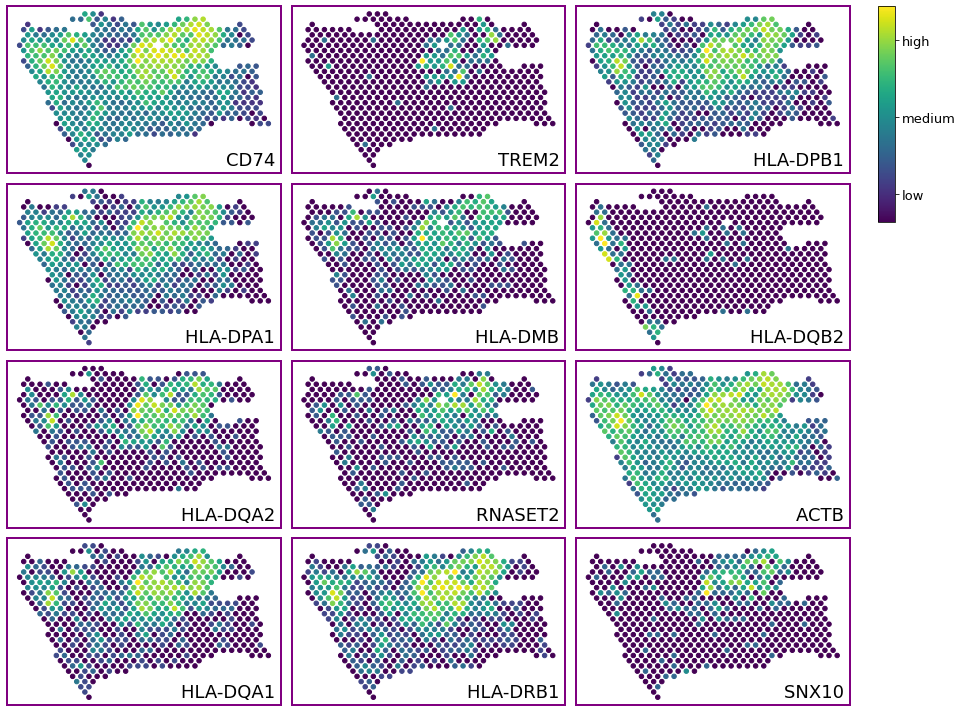

In [21]:
sample_SPECIMEN_list = ['P18554_1001_50107-A']
timestamp = '20220511' # the timestamp of the files (check filename)
for sample_SPECIMEN in sample_SPECIMEN_list:
    # Subset adata 
    adata_sample_SPECIMEN = adata[(adata.obs['sample_SPECIMEN']== sample_SPECIMEN)].copy()
    
    # Load the data for the particular sample
    results = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_results_' + sample_SPECIMEN + '.csv')
    sample_info = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_sample_info_' + sample_SPECIMEN + '.csv')
    counts = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_counts_' + sample_SPECIMEN + '.csv')
    norm_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_norm_expr_' + sample_SPECIMEN + '.csv')
    resid_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_resid_expr_' + sample_SPECIMEN + '.csv')
    
    genes = results.sort_values('qval').head(12)['g'].tolist()
    # Plot genes in spatial slides - top 12 by qval
    fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(12, 10))
    for i, g in enumerate(genes):
        ax = plt.subplot(4, 3, i + 1)
        ax.spines[:].set_color('purple')
        ax.spines[:].set_linewidth(2)
        ax.tick_params(axis='both',          # changes apply to the x-axis
                       which='both',      # both major and minor ticks are affected
                       bottom=False,      # ticks along the bottom edge are off
                       top=False, # ticks along the top edge are off
                       left=False, 
                       right=False, # ticks along the top edge are off
                       labelleft=False,
                       labelbottom=False) # labels along the bottom edge are off
        if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
            ax.invert_xaxis() 
            ax.invert_yaxis()
        im = plt.scatter(sample_info['array_col'], -1.5*sample_info['array_row'], c = norm_expr[g], s = 20);
        plt.title(g + ' ', fontsize=18)
        plt.colorbar().remove()
    
    fig.tight_layout()
#     fig.subplots_adjust(bottom=0.1, top=0.9, left=0.2, right=0.8,
#                     wspace=0.02, hspace=0.02)
    cb_ax = fig.add_axes([1.02, 0.685, 0.02, 0.3]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax = cb_ax)
    cbar.set_ticks(np.arange(-0.25, 2.5, 1.2))
    cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)
    
    #plt.savefig('Figure3_SpatialDE/' + 'Top12_tight' + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()    

## Spatially variable genes and FSV

In [12]:
adata

AnnData object with n_obs × n_vars = 15777 × 15107
    obs: 'indexes', 'sample', 'project', 'slide', 'in_tissue', 'array_row', 'array_col', 'ANNOTATOR', 'DISEASE', 'disease', 'SAMPLE', 'LESIONAL', 'NON LESIONAL', 'upper EPIDERMIS', 'middle EPIDERMIS', 'basal EPIDERMIS', 'DERMIS', 'DERdepth1', 'DERdepth2', 'DERdepth3', 'DERdepth4', 'DERdepth5', 'DERdepth6', 'DERdepth7', 'INTERFACE', 'VESSEL', 'HAIR FOLLICLE', 'SWEAT GLAND', 'SEBACEOUS GLAND', 'MUSCLE', 'FAT TISSUE', 'KERATINOCYTE', 'ENDOTHELIAL', 'GRANULOMA', 'BIOBANK', 'SPECIMEN', 'GA', 'GNL', 'GSC', 'GSS', 'EPIDERMIS', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'library_id', 'batch', 'specimen', 'patient', 'biopsy_type', 'cell_type', 'tissue_type', 'skin_layer', 'spot_type', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors', 'leiden_r5', 'leiden_r3', 'leiden_r1.5', 'leiden_r1.3', 'leiden_r1.0', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.3', 'leiden_r5_patient', 'leiden_r3_patient', 'leiden_r1.5_patien

In [8]:
adata.obs['mt_frac']

0        0.049793
1        0.091025
2        0.055118
3        0.058313
4        0.024649
           ...   
15772    0.111111
15773    0.061989
15774    0.038614
15775    0.079648
15776    0.081600
Name: mt_frac, Length: 15777, dtype: float32

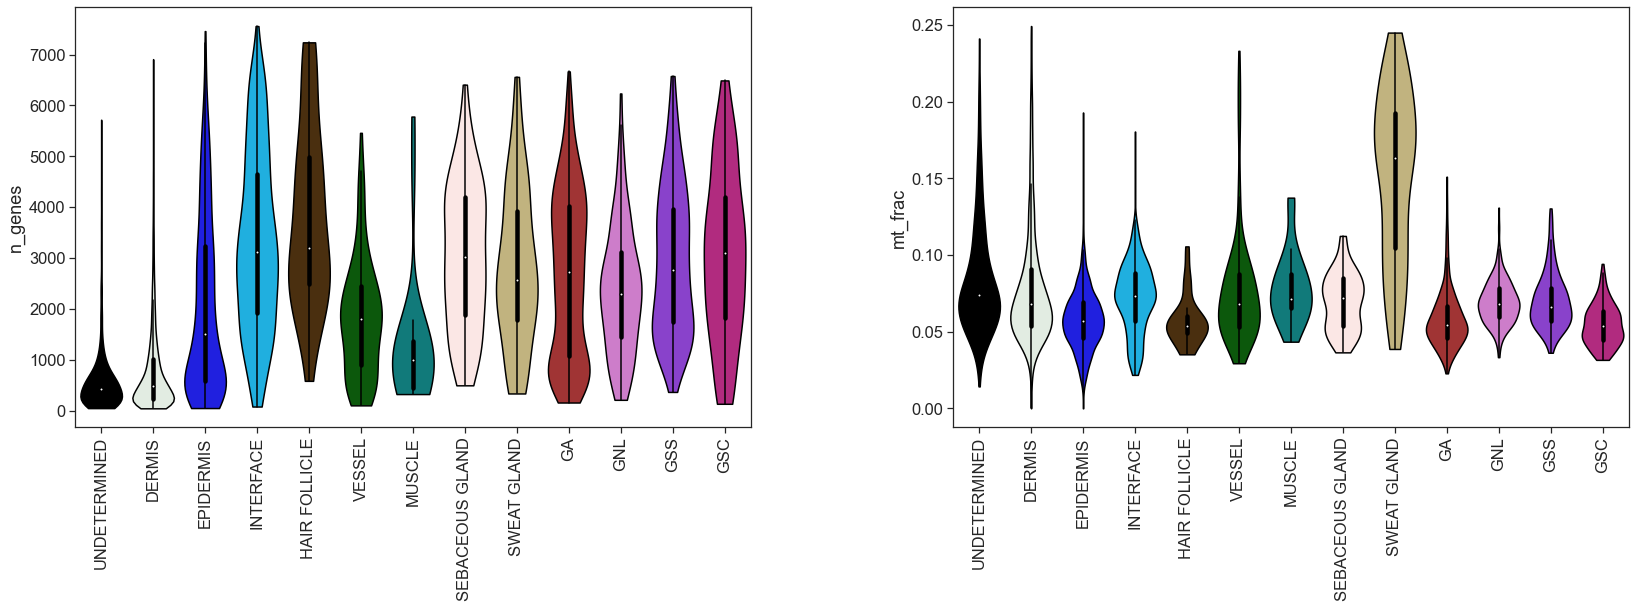

In [44]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.5)
with plt.rc_context({'figure.figsize': (10, 8)}):
    sc.pl.violin(adata, ['n_genes', 'mt_frac'], groupby = 'spot_type', 
                 stripplot=False, inner='box', rotation = 90, # use stripplot=False to remove the internal dots, inner='box' adds a boxplot inside violins
                 palette = spot_colors)

Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.


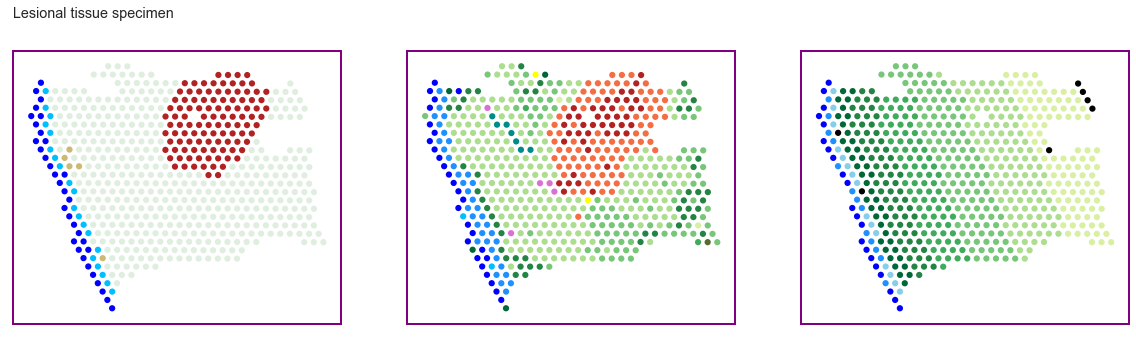

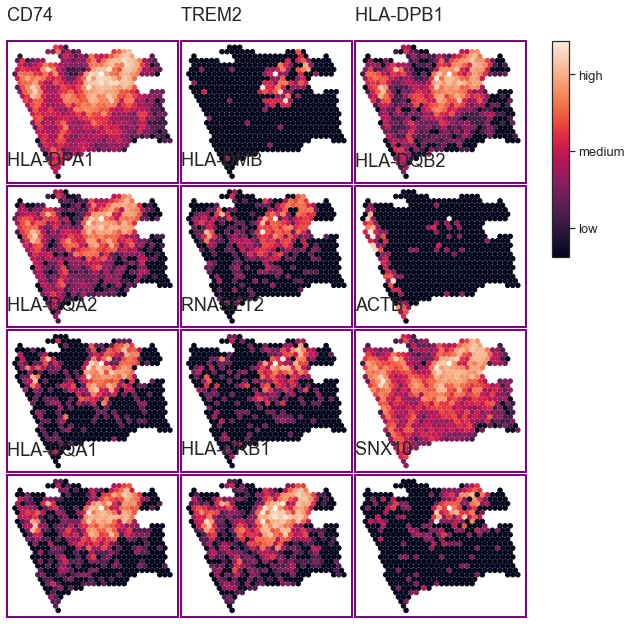

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1]})
plt.rcParams['axes.titley'] = 1.1 # height of the titles
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams['axes.titlesize'] = 'x-large'

## spot type
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
              library_id = 'P18554_1001', 
              ax = ax[0], title= 'Lesional tissue specimen', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax[0].title.set_size(30)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].axis = 'off'
ax[0].spines[:].set_color('purple') 
ax[0].spines[:].set_linewidth(2)

## leiden clusters
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
              library_id = 'P18554_1001', 
              ax = ax[1], title= '', 
              color = 'leiden_r1.3_patient', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
                                  'leiden_r1.3_patient', leiden_r13_colours),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax[1].title.set_size(18)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].axis = 'off'
ax[1].spines[:].set_color('purple') 
ax[1].spines[:].set_linewidth(2)

## dermis depth
sc.pl.spatial(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
              library_id = 'P18554_1001', 
              ax = ax[2], title= '', 
              color = 'skin_layer', show = False,
              palette = _set_colors(adata[adata.obs['sample_SPECIMEN']=='P18554_1001_50107-A'],
                                  'skin_layer', dermis_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
ax[2].title.set_size(18)
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].axis = 'off'
ax[2].spines[:].set_color('purple') 
ax[2].spines[:].set_linewidth(2)

sample_SPECIMEN_list = ['P18554_1001_50107-A']
timestamp = '20220511' # the timestamp of the files (check filename)
for sample_SPECIMEN in sample_SPECIMEN_list:
    # Subset adata 
    adata_sample_SPECIMEN = adata[(adata.obs['sample_SPECIMEN']== sample_SPECIMEN)].copy()
    
    # Load the data for the particular sample
    results = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_results_' + sample_SPECIMEN + '.csv')
    sample_info = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_sample_info_' + sample_SPECIMEN + '.csv')
    counts = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_counts_' + sample_SPECIMEN + '.csv')
    norm_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_norm_expr_' + sample_SPECIMEN + '.csv')
    resid_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_resid_expr_' + sample_SPECIMEN + '.csv')
    
    genes = results.sort_values('qval').head(12)['g'].tolist()
    # Plot genes in spatial slides - top 12 by qval
    fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(12, 10))
    for i, g in enumerate(genes):
        ax = plt.subplot(4, 3, i + 1)
        ax.spines[:].set_color('purple')
        ax.spines[:].set_linewidth(2)
        ax.tick_params(axis='both',          # changes apply to the x-axis
                       which='both',      # both major and minor ticks are affected
                       bottom=False,      # ticks along the bottom edge are off
                       top=False, # ticks along the top edge are off
                       left=False, 
                       right=False, # ticks along the top edge are off
                       labelleft=False,
                       labelbottom=False) # labels along the bottom edge are off
        if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
            ax.invert_xaxis() 
            ax.invert_yaxis()
        im = plt.scatter(sample_info['array_col'], -1.5*sample_info['array_row'], c = norm_expr[g], s = 20);
        plt.title(g + ' ', fontsize=18)
        plt.colorbar().remove()
    
    
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.2, right=0.8,
                    wspace=0.02, hspace=0.02)
    cb_ax = fig.add_axes([0.83, 0.6, 0.02, 0.3]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax = cb_ax)
    cbar.set_ticks(np.arange(-0.25, 2.5, 1.2))
    cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)
    
    #plt.savefig('Figure3_SpatialDE/' + 'Top12' + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()    


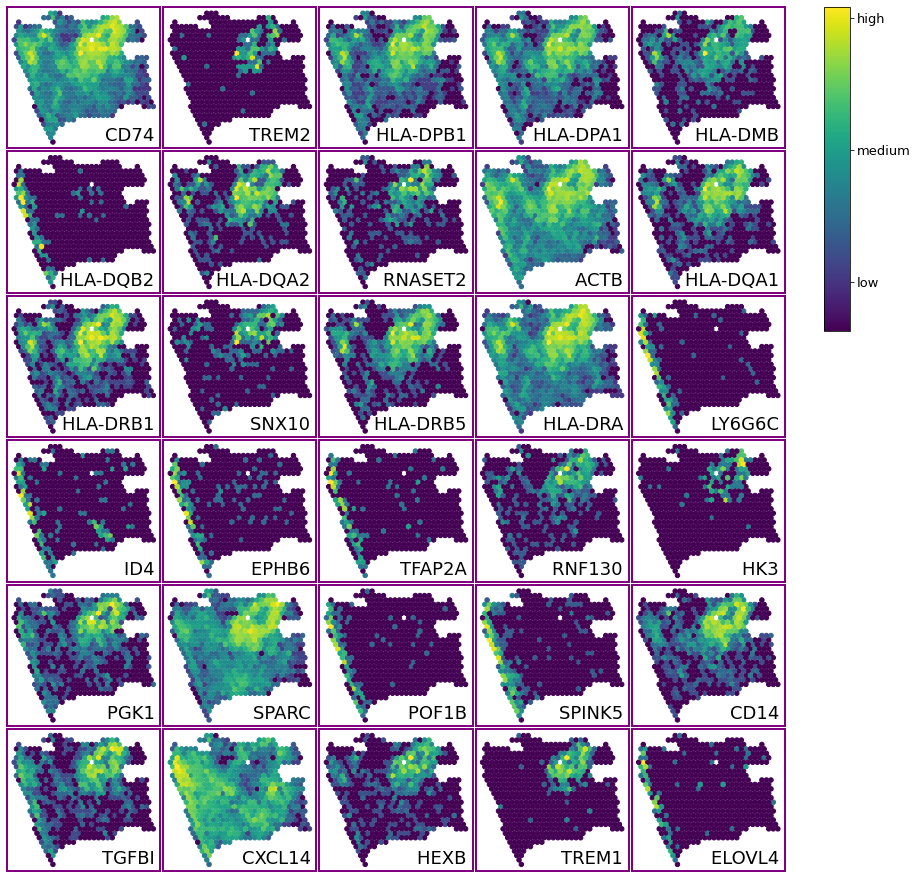

In [19]:
sample_SPECIMEN_list = ['P18554_1001_50107-A']
timestamp = '20220511' # the timestamp of the files (check filename)

plt.rcParams['axes.titley'] = 0.01 # height of the titles
plt.rcParams['axes.titlelocation'] = 'right'

for sample_SPECIMEN in sample_SPECIMEN_list:
    # Subset adata 
    adata_sample_SPECIMEN = adata[(adata.obs['sample_SPECIMEN']== sample_SPECIMEN)].copy()
    
    # Load the data for the particular sample
    results = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_results_' + sample_SPECIMEN + '.csv')
    sample_info = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_sample_info_' + sample_SPECIMEN + '.csv')
    counts = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_counts_' + sample_SPECIMEN + '.csv')
    norm_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_norm_expr_' + sample_SPECIMEN + '.csv')
    resid_expr = pd.read_csv('Figure3_SpatialDE/' + timestamp + '_resid_expr_' + sample_SPECIMEN + '.csv')
    
    genes = results.sort_values('qval').head(30)['g'].tolist()
    # Plot genes in spatial slides - top 12 by qval
    fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(18, 15))
    for i, g in enumerate(genes):
        ax = plt.subplot(6, 5, i + 1)
        ax.spines[:].set_color('purple')
        ax.spines[:].set_linewidth(2)
        ax.tick_params(axis='both',          # changes apply to the x-axis
                       which='both',      # both major and minor ticks are affected
                       bottom=False,      # ticks along the bottom edge are off
                       top=False, # ticks along the top edge are off
                       left=False, 
                       right=False, # ticks along the top edge are off
                       labelleft=False,
                       labelbottom=False) # labels along the bottom edge are off
        if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
            ax.invert_xaxis() 
            ax.invert_yaxis()
        im = plt.scatter(sample_info['array_col'], -1.5*sample_info['array_row'], c = norm_expr[g], s = 20);
        plt.title(g + ' ', fontsize=18)
        plt.colorbar().remove()
    
    
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.2, right=0.8,
                    wspace=0.02, hspace=0.02)
    cb_ax = fig.add_axes([0.83, 0.6, 0.02, 0.3]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax = cb_ax)
    cbar.set_ticks(np.arange(-0.25, 2.5, 1.2))
    cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)
    
    #plt.savefig('Figure3_SpatialDE/' + 'Top12' + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()    

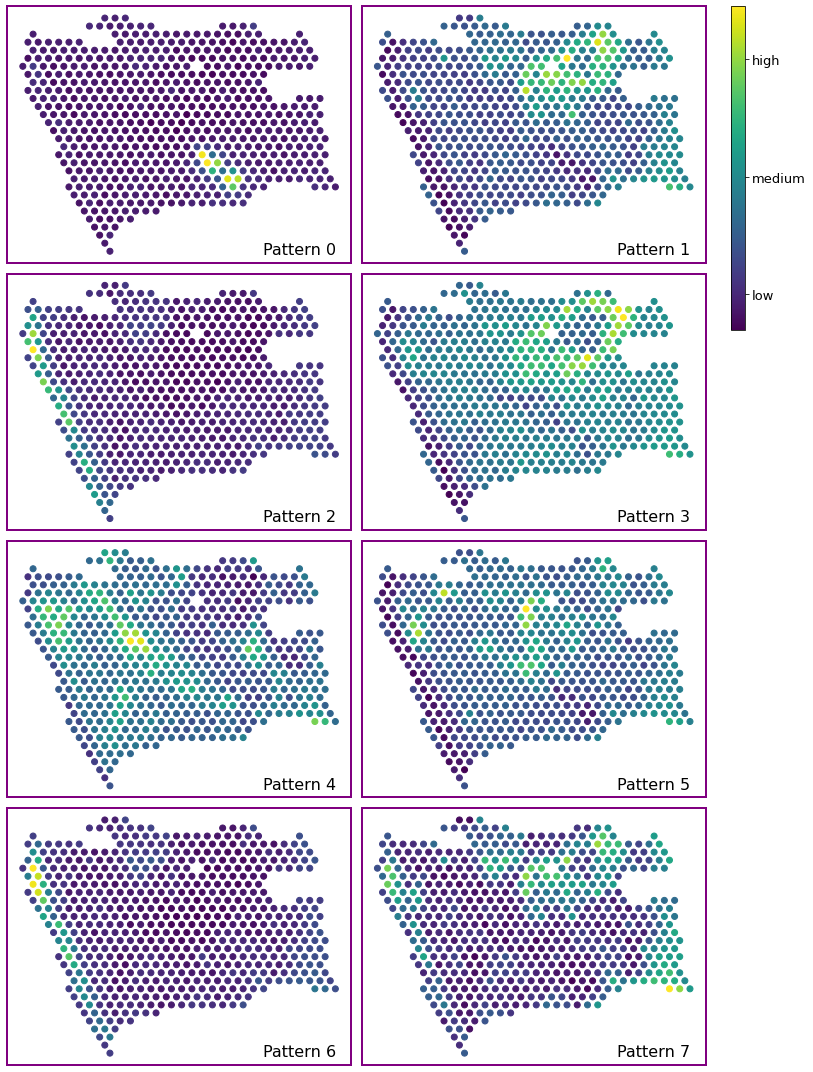

In [22]:
adata_subset = df_all[(df_all['sample_SPECIMEN']== 'P18554_1001_50107-A')] # define here the sample_SPECIMEN you want to display

plt.rcParams['axes.titley'] = 0.01 # height of the titles
plt.rcParams['axes.titlelocation'] = 'right'

fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(10, 15))
for i, pattern in enumerate(patterns_columns):
    ax = plt.subplot(4, 2, i + 1)
    #ax.set_axis_off() # this removes everything around
    ax.spines[:].set_color('purple')
    ax.spines[:].set_linewidth(2)
    ax.tick_params(axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False, # ticks along the top edge are off
                    left=False, 
                    labelleft=False,
                    labelbottom=False) # labels along the bottom edge are off
    
    im = plt.scatter(adata_subset['array_col'], 
                -1.5*adata_subset['array_row'],
                c = adata_subset[pattern]) # define here the pattern you want to display
    plt.title('Pattern {}   '.format(i), fontsize=16)
    plt.colorbar().remove()
#     if(i != 3):
#         plt.colorbar().remove()
#     else:
#         cbar = plt.colorbar() # get the colour bar for the last plot
#         cbar.set_ticks(np.arange(adata_subset[pattern].min() + 0.4, 
#                                  adata_subset[pattern].max() - 0.4, 
#                                  (adata_subset[pattern].max() - adata_subset[pattern].min())/3))
#         cbar.set_ticklabels(['low', 'medium', 'high'])
#         plt.colorbar().remove() 
#         cbar.remove()
fig.tight_layout()
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
#                     wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([1.02, 0.69, 0.02, 0.3])# left, bottom, width, height
cbar = fig.colorbar(im, cax = cb_ax)
cbar.set_ticks(np.arange(-0.25, 1.25, 0.72))
cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)

plt.savefig('Figure3_SpatialDE/patterns_sharedlegend_tight.png', facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
# Plot patterns in a specific order 
# -------------------------------------------------------------------------------------------------------
# Input: It takes the anndata object, the patterns dataframe and a pattern list of the sample_SPECIMEN_pattern(s) in the order you want them plotted,
# Note: the patternsdf must have the following columns: spot_index, array_row, array_col, sample_SPECIMEN and a column for each of the patterns (0, 1, 2...)
# Output: A figure with 3 rows (pattern, spot type, leiden_clustering) of each of the sample_SPECIMEN_patterns in the given order

# for debug:
# pattern_list_example = ['P17851_1002_91253-A_pattern6', 'P17851_1003_45703-A_pattern7', 'P17851_1004_45703-A_pattern6']

def plot_in_order_annotations(anndata, patternsdf, patternlist, list_of_annotations, col_number = 8):
    # Input: each element of this list is in turn a list of the sample_SPECIMEN_pattern(s) you want to include in the analysis.
    sample_SPECIMEN_pattern_list_of_lists = [patternlist] # If you only want to plot 1 group, then just add it as a list of a list e.g., [['P17851_1001_91253-A_pattern0', 'P17851_1002_91253-A_pattern4']]
    adata = anndata
    all_patterns_df = patternsdf

    number_of_columns = int(col_number)
    number_of_rows_per_category = math.ceil(int(len(patternlist))/number_of_columns) # if there are too many patters we'll divide them in several rows
    number_of_rows = (int(len(list_of_annotations)) + 3) * number_of_rows_per_category
    
    # Loop for each sample_SPECIMEN_pattern
    # -------------------------------------------------------------------------------------------------------
    for k, sample_SPECIMEN_pattern_list in enumerate(sample_SPECIMEN_pattern_list_of_lists):
        fig,axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(5*number_of_columns, int(4 * number_of_rows)))
        for i, sample_SPECIMEN_pattern in enumerate(sample_SPECIMEN_pattern_list):
            sample_SPECIMEN = sample_SPECIMEN_pattern.split('_pattern')[0]
            pattern_number = sample_SPECIMEN_pattern.split('_pattern')[1]
        #     print(sample_SPECIMEN)
        #     print(pattern_number)

            #Subset the data
            adata_sample_SPECIMEN = adata[(adata.obs['sample_SPECIMEN']== sample_SPECIMEN)].copy()
            all_patterns_df_temp = all_patterns_df[all_patterns_df['sample_SPECIMEN'] == sample_SPECIMEN]
            
            # Plotting subplots
            ax = plt.subplot(number_of_rows, number_of_columns, i + 1)
            if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
                ax.invert_xaxis() 
                ax.invert_yaxis()
            plt.scatter(all_patterns_df_temp['array_col'], -1.5*all_patterns_df_temp['array_row'], c = all_patterns_df_temp[str(pattern_number)], s = 80); # Note: if patterns.csv is read in, you might need to change it to patterns[str(i)] 
            plt.axis('equal')
            plt.title(sample_SPECIMEN_pattern, fontsize = 15)
            plt.colorbar().remove()
            #plt.colorbar(ticks=[all_patterns_df_temp[str(pattern_number)].min(), 0, all_patterns_df_temp[str(pattern_number)].max()]);
            ax.spines[:].set_color('purple')
            ax.spines[:].set_linewidth(2)
            ax.tick_params(axis='both',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False, # ticks along the top edge are off
                            left=False, 
                            labelleft=False,
                            labelbottom=False) # labels along the bottom edge are off
    
            ax = plt.subplot(number_of_rows, number_of_columns, i + 1 + number_of_rows_per_category * number_of_columns)
            if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
                ax.invert_xaxis() 
                ax.invert_yaxis()
            plt.scatter(adata_sample_SPECIMEN.obs['array_col'], -1.5*adata_sample_SPECIMEN.obs['array_row'], c = adata_sample_SPECIMEN.obs['spot_type'].map(spot_colors), s = 80); # Note: if patterns.csv is read in, you might need to change it to patterns[str(i)] 
            plt.axis('equal')
            #plt.title(sample_SPECIMEN_pattern + '\n coloured by spot type')
            ax.spines[:].set_color('purple')
            ax.spines[:].set_linewidth(2)
            ax.tick_params(axis='both',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False, # ticks along the top edge are off
                            left=False, 
                            labelleft=False,
                            labelbottom=False) # labels along the bottom edge are off
            
            ax = plt.subplot(number_of_rows, number_of_columns, i + 1 + 2 * number_of_rows_per_category * number_of_columns)
            if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
                ax.invert_xaxis() 
                ax.invert_yaxis()
            plt.scatter(adata_sample_SPECIMEN.obs['array_col'], -1.5*adata_sample_SPECIMEN.obs['array_row'], c = adata_sample_SPECIMEN.obs['leiden_r1.3_patient'].map(leiden_r13_colours), s = 80); # Note: if patterns.csv is read in, you might need to change it to patterns[str(i)] 
            plt.axis('equal')
            #plt.title(sample_SPECIMEN_pattern + '\n coloured by leiden clusters (r = 1.3)')
            ax.spines[:].set_color('purple')
            ax.spines[:].set_linewidth(2)
            ax.tick_params(axis='both',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False, # ticks along the top edge are off
                            left=False, 
                            labelleft=False,
                            labelbottom=False) # labels along the bottom edge are off
            
            for j, annotation in enumerate(list_of_annotations):
                ax = plt.subplot(number_of_rows, number_of_columns, i + 1 + (3 + j) * number_of_rows_per_category * number_of_columns)
                if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
                    ax.invert_xaxis() 
                    ax.invert_yaxis()
                plt.scatter(adata_sample_SPECIMEN.obs['array_col'], -1.5*adata_sample_SPECIMEN.obs['array_row'], c = adata_sample_SPECIMEN.obs[annotation], s = 80); # Note: if patterns.csv is read in, you might need to change it to patterns[str(i)] 
                plt.axis('equal')
                plt.title(sample_SPECIMEN_pattern + '\n coloured by ' + annotation)

Trying to set attribute `._uns` of view, copying.


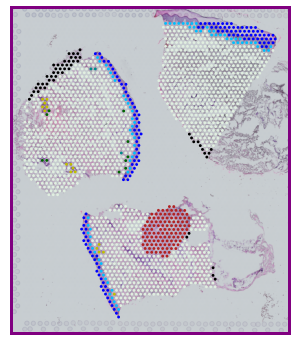

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.spatial(adata[adata.obs['sample']=='P18554_1001'],
              library_id = 'P18554_1001', 
              ax = ax, title= '', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample']=='P18554_1001'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = 'hires', alpha_img = 1, alpha = 1,
              frameon = True)
# for the frame around the image
ax.spines[:].set_color('purple') 
ax.spines[:].set_linewidth(3)
# x and y labels
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis = 'off'

In [27]:
adata.obs['sample'].unique

<bound method Series.unique of 0        P17851_1001
1        P17851_1001
2        P17851_1001
3        P17851_1001
4        P17851_1001
            ...     
15772    P18554_1008
15773    P18554_1008
15774    P18554_1008
15775    P18554_1008
15776    P18554_1008
Name: sample, Length: 15777, dtype: category
Categories (12, object): ['P17851_1001', 'P17851_1002', 'P17851_1003', 'P17851_1004', ..., 'P18554_1005', 'P18554_1006', 'P18554_1007', 'P18554_1008']>

Trying to set attribute `._uns` of view, copying.


NameError: name 'g' is not defined

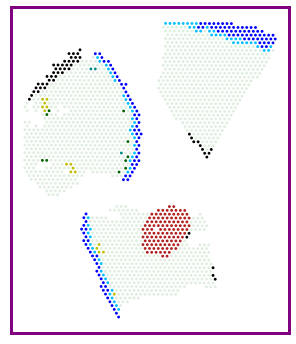

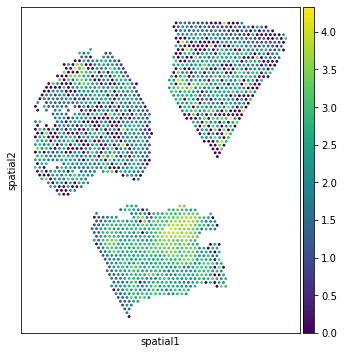

In [24]:

fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.spatial(adata[adata.obs['sample']=='P18554_1001'],
              library_id = 'P18554_1001', 
              ax = ax, title= '', 
              color = 'spot_type', show = False,
              palette = _set_colors(adata[adata.obs['sample']=='P18554_1001'],
                                  'spot_type', spot_colors),
              legend_loc = 'None', # to remove the legend
              size = 1, img_key = None, alpha_img = 1, alpha = 1)
# for the frame around the image
ax.spines[:].set_color('purple') 
ax.spines[:].set_linewidth(3)

ax.set_xlabel('')
ax.set_ylabel('')
ax.axis = 'off'

sample_SPECIMEN_list = ['P18554_1001_50107-A']
timestamp = '20220511' # the timestamp of the files (check filename)

plt.rcParams['axes.titley'] = 0.01 # height of the titles
plt.rcParams['axes.titlelocation'] = 'right'

for i, sample in enumerate(adata.obs['sample'].unique):
    # Subset adata 
    adata_sample = adata[(adata.obs['sample']== sample)].copy()
    
    # Plot spatial slides
    fig, axes = plt.subplots(facecolor='w', edgecolor='k', figsize=(18, 15))
    for i, g in enumerate(genes):
        ax = plt.subplot(6, 5, i + 1)
        ax.spines[:].set_color('purple')
        ax.spines[:].set_linewidth(2)
        ax.tick_params(axis='both',          # changes apply to the x-axis
                       which='both',      # both major and minor ticks are affected
                       bottom=False,      # ticks along the bottom edge are off
                       top=False, # ticks along the top edge are off
                       left=False, 
                       right=False, # ticks along the top edge are off
                       labelleft=False,
                       labelbottom=False) # labels along the bottom edge are off
        if ((adata_sample_SPECIMEN.obs['sample'].unique() == 'P17851_1002') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1006') | (adata_sample_SPECIMEN.obs['sample'].unique() == 'P18554_1002')):
            ax.invert_xaxis() 
            ax.invert_yaxis()
        im = plt.scatter(sample_info['array_col'], -1.5*sample_info['array_row'], c = norm_expr[g], s = 20);
        plt.title(g + ' ', fontsize=18)
        plt.colorbar().remove()
    
    
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.2, right=0.8,
                    wspace=0.02, hspace=0.02)
    cb_ax = fig.add_axes([0.83, 0.6, 0.02, 0.3]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax = cb_ax)
    cbar.set_ticks(np.arange(-0.25, 2.5, 1.2))
    cbar.set_ticklabels(['low', 'medium', 'high'], fontsize=13)
    
    #plt.savefig('Figure3_SpatialDE/' + 'Top12' + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()    